You can just skip both links at the first

Eric's note. SLAC Specific instruction
https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=245696522
More general, complete note provided by DM
https://nb.lsst.io/science-pipelines/science-pipelines-in-notebooks.html

Open a terminal window from the above File menu. Click `File` -> move a cursor to `New` and click `Terminal`

Then follow the instruction below. download EO utilities
```
$ mkdir src
$ cd src/
$ git clone https://github.com/lsst-camera-dh/EO-utilities.git
$ git clone https://github.com/lsst-camera-dh/datacat-utilities.git
$ wget https://files.pythonhosted.org/packages/57/76/7b745031b9c67e4e7a8aa760a599976347efee9cd0c775051808f50f6d3c/datacat-0.5.tar.gz
$ tar xvzf datacat-0.5.tar.gz
```

edit ~/notebooks/.user_setups
add
```
export PYTHONPATH="~/src/EO-utilities/python":${PYTHONPATH}
export PYTHONPATH="~/src/datacat-utilities/python":${PYTHONPATH}
export PYTHONPATH="~/src/datacat-0.5":${PYTHONPATH}
source /gpfs/slac/lsst/fs3/g/data/software/jh_install/prod/setup.sh
```

You should be ready for using SLAC data by here.

The below lines are things you need first. For now just execute by hitting "shift"+"return"

In [2]:
from lsst import afw
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil

If you only see the version number of 19.0.0, your environment should be ok.

---

We have a couple of different flats
- CCOB flat (BOT)
- TS8 flat
- BOT flat taken with Flat Projector

We'll be exploring those images by this notebook.
https://confluence.slac.stanford.edu/display/LSSTCAM/Flat+comparison

# CCOB flat
The synthesized flats are stored in `/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits`
Let's see the content by using the following command. There are five images for each sensor. Image acquisition was done by placing the projector in the X shape. The one has the projector in the closest to the CCD center is considered as a good image. In file name, there is a projector position in the BOT coordinate. Assuming the following case: 

In [3]:
!ls /gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits | head -5

QE_R01_S00_nm960_-285.985_-159.785.fits
QE_R01_S00_nm960_-285.985_-180.145.fits
QE_R01_S00_nm960_-295.985_-169.965.fits
QE_R01_S00_nm960_-305.985_-159.785.fits
QE_R01_S00_nm960_-305.985_-180.145.fits
ls: write error: Broken pipe


`QE_R12_S00_nm960_-169.185_-42.565.fits` is the best one. Let's take this one as an example:
`/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits`

Let's see the image. The first step is to load an image on memory. get_ccd_from_id return MaskedCCD object with a fits file you specified

In [4]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccd = get_ccd_from_id(None, fname, [])

Display the image with the following function.

In [30]:
import pylab
%matplotlib inline
from astropy.stats import mad_std

def showMaskedCCD(exp, N=3):
    fig, axs = pylab.subplots(2,8,figsize=(5,5),dpi=300)   # create an environment for multiple plot
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.)
    for i, amp in enumerate(range(1,17)):                  # loop this over 16 semgents
        ff_det = get_data_as_read(exp, amp, ['imaging'])   # get a specified segment
        mean = ff_det["imaging"].mean()                    # take an average for visualization
        std = mad_std(ff_det["imaging"])                   # take a Median Abosolute Deviation as an estimator for standard deviation
        row = int(i/8)
        col = i%8    
        ax = axs[row][col]
        if row==1:
            origin="lower"
        else:
            origin=None
        ax.imshow(ff_det["imaging"],origin=origin,vmin=mean-N*std,vmax=mean+N*std)
        ax.annotate("{:02d}".format(i),(0.1,0.05),xycoords="axes fraction")
        ax.set_xticks([])
        ax.set_yticks([])
    pylab.show()

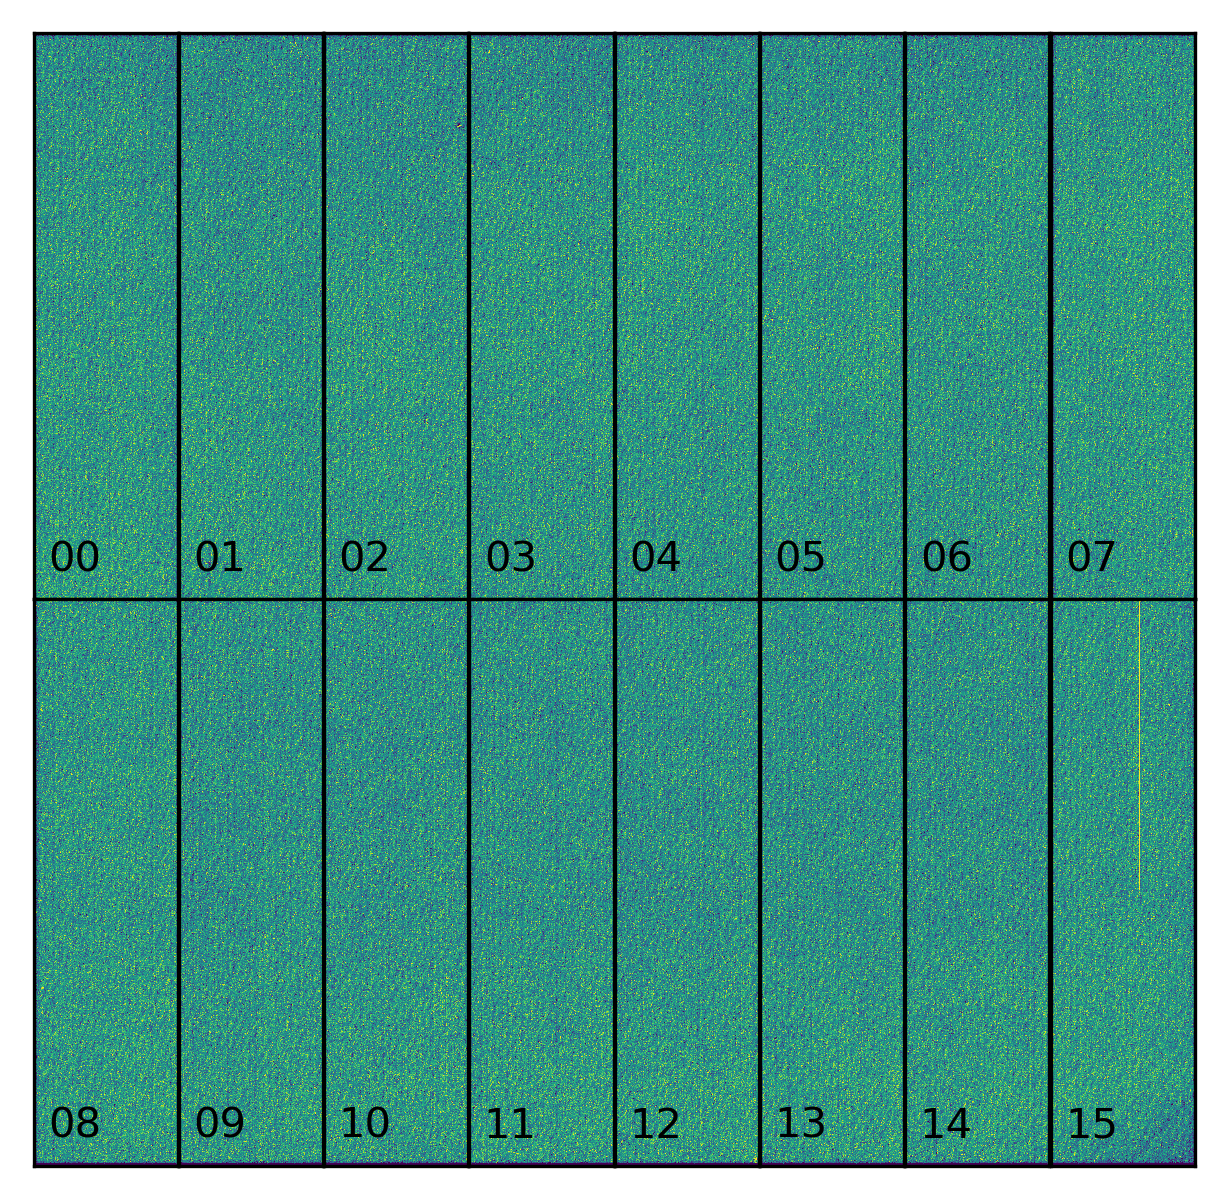

In [31]:
showMaskedCCD(ccd)

# TS8 flat
First we need to figure out which Raft we were looking at. A MaskedCCD object has a information about it. Let's see how it looks.

In [7]:
print(ccd.md.md)

SIMPLE = 1
BITPIX = 8
NAXIS = 0
EXTEND = 1
DATE = "2019-10-29T00:31:19.004"
DATE-OBS = "2019-10-29T00:31:16.602"
MJD = 58785.021747732
MJD-OBS = 58785.021719931
RUNNUM = "6849D"
IMAGETAG = "712568627e31b920"
TSTAND = "BOT"
INSTRUME = "lsstCam"
CONTNUM = "18edfb14"
SEQFILE = "FP_ITL_2s_ir2_v3.seq"
CCDSLOT = "S21"
RAFTBAY = "R02"
LSST_NUM = "ITL-3800C-318"
RAFTNAME = "LCA-11021_RTM-013"
TESTTYPE = "CCOB"
IMGTYPE = "CCOB"
SEQNUM = 4900
DETSIZE = "[1:4072,1:4000]"
CCDTEMP = -102.95257939921
EXPTIME = 0.070000000000000
BINX = 1
BINY = 1
HEADVER = 2
CCDGAIN = 1.0000000000000
CCDNOISE = 10.000000000000
DATE-TRG = "2019-10-29T00:31:16.602"
MJD-TRG = 58785.021719931
FIRMWARE = "31345004"
PLATFORM = "ir2-camera"
DAQVERS = "R4-V2.7 2019-10-25T19:27:48Z (52b5939b)"
DAQPART = "camera"
DAQFOLD = "raw"
DAQANNOT = ""
OBSID = "MC_C_20191028_004900"
TELCODE = "MC"
CONTRLLR = "C"
DAYOBS = "20191028"
TELESCOP = "LSST"
SEQCKSUM = "4046586556"
DARKTIME = 0.19500000000000
TSEQNUM = 225
TEMPLED1 = 20.31054310

You can find what Raft name is by looking at the above output, but specifying a keyword argument will only print what you specified

In [8]:
ccd.md.md["RAFTNAME"]

'LCA-11021_RTM-013'

So this is RTM-013.

Then you have to pick a run number from the table.

Looking at this page List of Good Runs, I can identify which is the good run. For this case Run 10982 is considered as the best for RTM-013. Then I can locate where they are. The below is one example.

/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superflat/RTM-013/RTM-013-10982-S21_superflat_normal_h.fits

You are now able to show the flat image.

In [9]:
get_data_as_read(exp, amp, ['imaging'])

NameError: name 'exp' is not defined